In [ ]:
#default_exp maml
#export
import logging
import warnings 

import higher
import kornia as K
import wandb
import pytorch_lightning as pl
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
from pytorch_lightning.metrics.functional import accuracy
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader
from unsupervised_meta_learning.pl_dataloaders import OmniglotDataModule

In [ ]:
%matplotlib inline

In [ ]:
#export
logger = logging.getLogger(__name__)

In [ ]:
#export
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, in_channels, out_features, hidden_size=64):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = hidden_size

        self.features = nn.Sequential(
            self.conv3x3(in_channels, hidden_size),
            self.conv3x3(hidden_size, hidden_size),
            self.conv3x3(hidden_size, hidden_size),
            self.conv3x3(hidden_size, hidden_size),
        )

        self.classifier = nn.Linear(hidden_size, out_features)

    def forward(self, inputs, params=None):
        features = self.features(inputs)
        features = features.view((features.size(0), -1))
        logits = self.classifier(features)
        return logits

    def conv3x3(self, in_channels, out_channels, **kwargs):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, **kwargs),
            nn.BatchNorm2d(out_channels, momentum=1.0, track_running_stats=False),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

In [ ]:
#export
def get_accuracy(logits, targets):
    """Compute the accuracy (after adaptation) of MAML on the test/query points
    Parameters
    ----------
    logits : `torch.FloatTensor` instance
        Outputs/logits of the model on the query points. This tensor has shape
        `(num_examples, num_classes)`.
    targets : `torch.LongTensor` instance
        A tensor containing the targets of the query points. This tensor has 
        shape `(num_examples,)`.
    Returns
    -------
    accuracy : `torch.FloatTensor` instance
        Mean accuracy on the query points
    """
    _, predictions = torch.max(logits, dim=-1)
    return torch.mean(predictions.eq(targets).float())

In [ ]:
#export
class MAML(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = get_accuracy
        self.automatic_optimization = False
    
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx, optimizer_idx):
        meta_optimizer, inner_optimizer = self.optimizers()
        meta_optimizer = meta_optimizer.optimizer
        inner_optimizer = inner_optimizer.optimizer
        
        train_inputs, train_targets = batch['train']
        test_inputs, test_targets = batch['test']
        
        batch_size = train_inputs.shape[0]
        outer_loss = torch.tensor(0., device=self.device)
        acc = torch.tensor(0., device=self.device)
        self.model.zero_grad()
        
        for task_idx, (train_input, train_target, test_input, test_target) in enumerate(
            zip(train_inputs, train_targets, test_inputs, test_targets)
        ):
#             inner_optimizer.zero_grad()
            with higher.innerloop_ctx(self.model, inner_optimizer, copy_initial_weights=False) as (fmodel, diffopt):
                train_logit = fmodel(train_input)
                inner_loss = F.cross_entropy(train_logit, train_target)
                
                diffopt.step(inner_loss)
                
                test_logit = fmodel(test_input)
                outer_loss += F.cross_entropy(test_logit, test_target)
                
                with torch.no_grad():
                    preds = test_logit.softmax(dim=-1)
                    acc += self.accuracy(test_logit, test_target)
                

#                     self.print(self.accuracy(test_logit, test_target))
                
        outer_loss.div_(batch_size)
        acc.div_(batch_size)
        self.log_dict({
                    'outer_loss': outer_loss,
                    'accuracy': acc
                }, prog_bar=True)
        
        meta_optimizer.zero_grad()
#         outer_loss.backward()

        self.manual_backward(outer_loss, meta_optimizer)
        meta_optimizer.step()
        
        return outer_loss
    
    def configure_optimizers(self):
        meta_optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        inner_optimizer = torch.optim.SGD(self.parameters(), lr=1e-1)
        
        return [meta_optimizer, inner_optimizer]
                
                

In [ ]:
#export
class UMTRA(pl.LightningModule):
    def __init__(self, model, augmentation):
        super().__init__()
        self.model = model
        self.accuracy = get_accuracy
        self.augmentation = augmentation
        self.automatic_optimization = False
    
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx, optimizer_idx):
        meta_optimizer, inner_optimizer = self.optimizers()
        meta_optimizer = meta_optimizer.optimizer
        inner_optimizer = inner_optimizer.optimizer
        
        train_inputs, train_targets = batch['train']
        test_inputs, test_targets = batch['test']
        
        batch_size = train_inputs.shape[0]
        outer_loss = torch.tensor(0., device=self.device)
        acc = torch.tensor(0., device=self.device)
        self.model.zero_grad()
        
        for task_idx, (train_input, train_target, test_input, test_target) in enumerate(
            zip(train_inputs, train_targets, test_inputs, test_targets)
        ):
#             inner_optimizer.zero_grad()
            val_input = self.augmentation(train_input).to(self.device)
            val_target = deepcopy(train_target).to(self.device)
            with higher.innerloop_ctx(self.model, inner_optimizer, copy_initial_weights=False) as (fmodel, diffopt):
                train_logit = fmodel(train_input)
                inner_loss = F.cross_entropy(train_logit, train_target)
                
                diffopt.step(inner_loss)
                
                val_logits = fmodel(val_input)
                outer_loss += F.cross_entropy(val_logits, val_target)
#                 test_logit = fmodel(test_input)
#                 outer_loss += F.cross_entropy(test_logit, test_target)
                
                with torch.no_grad():
                    test_logits = fmodel(test_input)
                    acc += self.accuracy(test_logits, test_target)
                

#                     self.print(self.accuracy(test_logit, test_target))
                
        outer_loss.div_(batch_size)
        acc.div_(batch_size)
        self.log_dict({
                    'outer_loss': outer_loss,
                    'accuracy': acc
                }, prog_bar=True)
        
        meta_optimizer.zero_grad()
#         outer_loss.backward()

        self.manual_backward(outer_loss, meta_optimizer)
        meta_optimizer.step()
        
        return outer_loss
    
    def configure_optimizers(self):
        meta_optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        inner_optimizer = torch.optim.SGD(self.parameters(), lr=1e-1)
        
        return [meta_optimizer, inner_optimizer]

In [ ]:
dm = OmniglotDataModule(
        "data",
        shots=1,
        ways=5,
        shuffle_ds=True,
        test_shots=15,
        meta_train=True,
        download=True,
        batch_size=16,
        shuffle=True,
        num_workers=8,
)

In [ ]:
dm.setup()
batch =dm.train_dataloader()

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    batch = next(iter(batch))

In [ ]:
batch['train'][1][1]

tensor([4, 2, 0, 3, 1])

In [ ]:
def c_imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

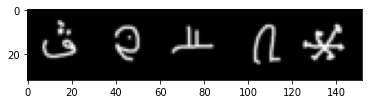

In [ ]:
c_imshow(torchvision.utils.make_grid(batch['train'][0][2]))

In [ ]:
model = MAML(model=ConvolutionalNeuralNetwork(1, 5, hidden_size=64))

In [ ]:
logger = WandbLogger(
    project='maml',
    config={
        'batch_size': 16,
        'steps': 100,
        'dataset': "omniglot"
    }
)
trainer = Trainer(
        profiler='simple',
        max_epochs=100,
        max_steps=100,
        fast_dev_run=False,
        num_sanity_val_steps=2, gpus=1, logger=logger
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    trainer.fit(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: p0int (use `wandb login --relogin` to force relogin)



  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | ConvolutionalNeuralNetwork | 112 K 
-----------------------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.449     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  37.018         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  25.132         	|1              	|  25.132         	|  67.89          	|
run_training_batch                 	|  0.23588        	|100            	|  23.588         	|  63.721         	|
model_forward                      	|  0.23573        	|100            	|  23.573         	|  63.68          	|
training_step                      	|  0.23543        	|100            	|  23.543         	|  63.599         	|
get_train_batch                    

In [ ]:
logger.finalize("success")

In [ ]:
wandb.finish()

outer_loss,0.29954
accuracy,0.90917
epoch,0
trainer/global_step,99
_runtime,29
_timestamp,1622904459
_step,1


outer_loss,█▁
accuracy,▁█
epoch,▁▁
trainer/global_step,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


In [ ]:
aug = nn.Sequential(
    K.augmentation.RandomAffine(degrees=0, translate=(0.4, 0.4), padding_mode='border'),
    K.augmentation.RandomGaussianNoise(mean=0., std=.1, p=.3)
)
model = UMTRA(model=ConvolutionalNeuralNetwork(1, 5, hidden_size=64), augmentation=aug)

In [ ]:
logger = WandbLogger(
    project='umtra',
    config={
        'batch_size': 16,
        'steps': 100,
        'dataset': "omniglot"
    }
)
trainer = Trainer(
        profiler='simple',
        max_epochs=100,
        max_steps=100,
        fast_dev_run=False,
        num_sanity_val_steps=2, gpus=1, logger=logger
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    trainer.fit(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name         | Type                       | Params
------------------------------------------------------------
0 | model        | ConvolutionalNeuralNetwork | 112 K 
1 | augmentation | Sequential                 | 0     
------------------------------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.449     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  36.018         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  31.24          	|1              	|  31.24          	|  86.733         	|
run_training_batch                 	|  0.29617        	|100            	|  29.617         	|  82.227         	|
model_forward                      	|  0.29602        	|100            	|  29.602         	|  82.185         	|
training_step                      	|  0.29571        	|100            	|  29.571         	|  82.099         	|
get_train_batch                    

In [ ]:
wandb.finish()

outer_loss,0.26876
accuracy,0.83417
epoch,0
trainer/global_step,99
_runtime,35
_timestamp,1622905873
_step,1


outer_loss,█▁
accuracy,▁█
epoch,▁▁
trainer/global_step,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


In [ ]:
from nbdev.export import notebook2script; notebook2script()

Converted 01_nn_utils.ipynb.
Converted 01b_data_loaders_pl.ipynb.
Converted 02_maml.ipynb.
Converted 02b_maml_pl.ipynb.
Converted 03_protonet_pl.ipynb.
Converted 04_cactus.ipynb.
Converted index.ipynb.
